<a href="https://colab.research.google.com/github/georgeliu1998/sentiment_word_embedding/blob/master/sentiment_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with Word Embedding and RNN

## Set up the Environment

In [1]:
import numpy as np
np.random.seed(8)
seed = np.random.RandomState(8)

import tensorflow as tf
tf.set_random_seed(8)

import urllib.request
import tarfile
import os
import re
import string
from time import time

import pandas as pd
import spacy
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, LSTM, GlobalAveragePooling1D
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [32]:
!python -m spacy download en_core_web_md

    100% |████████████████████████████████| 120.9MB 44.6MB/s 
  Running setup.py install for en-core-web-md ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [39]:
!python -m spacy download en_vectors_web_lg

    100% |████████████████████████████████| 661.8MB 45.3MB/s 
  Running setup.py install for en-vectors-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_vectors_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_vectors_web_lg

    You can now load the model via spacy.load('en_vectors_web_lg')



## Get the Data

In [0]:
url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

path = './gdrive/My Drive/WorkingDir/sentiment_word_embedding'
download_folder = 'raw_data'
download_name = 'imdb.tar.gz'
path_name = os.path.join(path, download_folder, download_name)

# Download data to the specified path
urllib.request.urlretrieve(url, path_name)

#extract_path = os.path.join(path, download_folder)

with tarfile.open(path_name) as tar:
  #tar.extractall(path=extract_path)
  tar.extractall()

('./gdrive/My Drive/WorkingDir/sentiment_word_embedding/raw_data/imdb.tar.gz',
 <http.client.HTTPMessage at 0x7fa4dbb55898>)

In [0]:
def load_imdb(path):
  """
  Loads train and test data into dataframes.

  Params
  ---------------------
  path: str
    The path to the unzipped aclImdb folder.

  Returns
  ---------------------
  df_train, df_test: tuple of of pandas df
    The dataframes created from data
  """

  data = {}

  for split in ['train', 'test']:
    data[split] = []

    for label in ['pos', 'neg']:
      sentiment = 1 if label == 'pos' else 0
      file_names = os.listdir(os.path.join(path, split, label))

      for file_name in file_names:
        file_path = os.path.join(path, split, label, file_name)
        with open(file_path, "r") as f:
          review = f.read()

          data[split].append([review, sentiment])

  np.random.shuffle(data['train'])        
  df_train = pd.DataFrame(data['train'], columns=['review', 'sentiment'])

  np.random.shuffle(data['test'])
  df_test = pd.DataFrame(data['test'], columns=['review', 'sentiment'])

  return df_train, df_test


def save_df(df, path, save_name):
  file_name = save_name + '.csv'
  path_name = os.path.join(path, file_name)
  
  df.to_csv(path_name, index=False)


def load_df():
  """
  Loads all train test dataframes
  """
  
  path = './gdrive/My Drive/WorkingDir/sentiment_word_embedding'
  
  df_train = pd.read_csv(os.path.join(path, 'df_train.csv'))
  df_test = pd.read_csv(os.path.join(path, 'df_test.csv'))
  
  return df_train, df_test 


def load_data_embedded():
  """
  Loads the spaCy embedded
  """
  path = './gdrive/My Drive/WorkingDir/sentiment_word_embedding'
  
  X_train = np.loadtxt(os.path.join(path, 'X_train_vector.csv'), delimiter=",")
  X_test = np.loadtxt(os.path.join(path, 'X_test_vector.csv'), delimiter=",")
  
  y_train, y_test = df_train['sentiment'], df_test['sentiment']

  return X_train, y_train, X_test, y_test

In [0]:
df_train, df_test = load_imdb('./aclImdb')

save_df(df=df_train, path=path, save_name='df_train')
save_df(df=df_test, path=path, save_name='df_test')

##  Clean Text

In [0]:
def preprocess_text(text, lemmatizing=False):
    """
    Preprocesses text by removing all stop words and lemmatizing.
    
    Params
    --------------
    text: str
      the string to be cleaned
    
    Returns
    --------------
    text: str
      the cleaned string

    """
    text = text.lower()
    
    if lemmatizing:
      lemmatizer = WordNetLemmatizer()
      text = ' '.join([lemmatizer.lemmatize(word, pos='v') for word in text.split()])
    
    # Remove html tags
    text = re.sub(r'<.*?>', '', text)
    
    # Replace punctuation with spaces
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator)

    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    
    # Remove additional white spaces
    text = ' '.join(text.split())
    
    return text

In [0]:
t1 = time()

X_train = df_train['review'].apply(preprocess_text)

t2 = time()

t = (t2 - t1) / 60

print('Took {} min'.format(t))

Took 14.381852738062541 min


In [0]:
df_train['review_processed'] = X_train
df_train.head()

,review,sentiment,review_processed
0,I could never remember the name of this show. ...,1,-0.037421
1,"Going into this movie, I had heard good things...",1,-0.009028
2,The only scary thing about this movie is the t...,0,-0.050488
3,This deserves a 12 out of 10. An absolutely re...,1,-0.047448
4,"Joan Fontaine is ""A Damsel in Distress"" in thi...",1,-0.060614


In [0]:
save_df(df=df_train, path=path, save_name='df_train')

In [0]:
t1 = time()

df_test['review_processed'] = df_test['review'].apply(preprocess_text)

t2 = time()

t = (t2 - t1) / 60

save_df(df=df_test, path=path, save_name='df_test')

print('Took {} min'.format(t))

Took 13.990289672215779 min


In [0]:
df_test.head()

,review,sentiment,review_processed
0,"""Thunderbolt"" is probably Jackie Chan's worst ...",0,thunderbolt probably jackie chan worst movie s...
1,This is the worst movie that I have ever seen....,0,worst movie ever seen first thought going good...
2,(Warning: Some spoilers ahead.)<br /><br />Wha...,0,warning spoilers ahead incredibly crappy movie...
3,This film is a perfect example of how to take ...,0,film perfect example take fascinating subject ...
4,"Ok, everybody agreed on what was the best seas...",1,ok everybody agreed best season first killing ...


## Split Data

In [0]:
def vectorize(df, col, vocab_size, max_length):
  """
  Vectorizes input texts by applying Keras one-hot encoding and padding
  
  Params
  ----------------------
  df: Pandas dataframe
    The dataframe to vectorize
  vocab_size: int
    Vocabulary size to use
  max_length: int
    Max length of reviews to use
  
  Returns
  ----------------------
  X: Numpy array  
    The vectorized feature column
  """
  X_oh = df[col].apply(lambda x: one_hot(text=x, n=vocab_size))
  # Convert to array of lists
  #X_oh = np.array([x for x in X_oh])
  # Keep only up to max length for each review
  X_oh = X_oh.apply(lambda x: x[0:max_length] if len(x)>max_length else x)
  # Pad reviews shorter than max_length with 
  X = pad_sequences(X_oh, maxlen=max_length, padding='post')
 
  return X


def load_data(df_train, 
              df_test, 
              col, 
              val_split=0.2, 
              vocab_size=110000, 
              max_length=200):
  """
  Loads the train, validation and test data as numpy arrays
  """
  X_train = vectorize(df=df_train, 
                      col=col, 
                      vocab_size=vocab_size,
                      max_length=max_length)
  y_train = df_train['sentiment']
  
  X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=val_split, 
                                                    random_state=seed)
  
  X_test = vectorize(df=df_test,
                     col=col,
                     vocab_size=vocab_size,
                     max_length=max_length)
  y_test = df_test['sentiment']
  
  return X_train, y_train, X_val, y_val, X_test, y_test 

In [33]:
df_train, df_test = load_df()

X_train, y_train, X_val, y_val, X_test, y_test = load_data(df_train, 
                                                           df_test, 
                                                           col='review_processed',
                                                           vocab_size=10000,
                                                           max_length=200)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((20000, 200), (20000,), (5000, 200), (5000,), (25000, 200), (25000,))

In [20]:
X_train

array([[ 91182,  66911,  80345, ...,      0,      0,      0],
       [ 58314,  34417,  88452, ...,      0,      0,      0],
       [107586, 109694,  63740, ...,      0,      0,      0],
       ...,
       [  4553,  15803,   1084, ...,      0,      0,      0],
       [ 32836,  88475,  54658, ...,      0,      0,      0],
       [ 34417,  50076,  97821, ...,      0,      0,      0]], dtype=int32)

## Exploratory Data Analysis

In [0]:
def get_vocab(df):
  """
  Gets the vocabulary in the review column and prints the size of the vocab
  
  Params
  ----------------------
  df: pandas dataframe
    The input dataframe
  
  Returns
  ----------------------
  vocab: Python set
    The unique vocabulary
  
  """
  vocab = set()
  
  for i in df['review_processed'].str.split():
    vocab.update(i)
  
  print("Vocabulary size: {}".format(len(vocab)))
  return vocab


def get_vocab_frequency(df):
  """
  
  """
  return df['review_processed'].str.split(expand=True).stack().value_counts()

In [8]:
vocab_train = get_vocab(df=df_train) 
vocab_test = get_vocab(df=df_test) 

Vocabulary size: 76298
Vocabulary size: 75456


In [9]:
vocab = set.union(vocab_train, vocab_test)
len(vocab)

104971

In [0]:
vocab

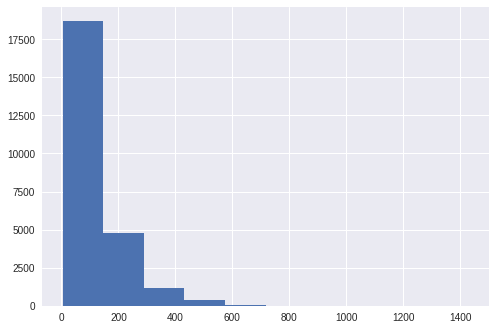

In [10]:
# Check the length distribution
df_train.review_processed.apply(lambda x: one_hot(x, len(vocab))).apply(lambda x: len(x)).hist()

In [14]:
vocab_freq_train = get_vocab_frequency(df_train)
vocab_freq_train

movie             44023
film              40140
one               26785
like              20270
good              15140
time              12720
even              12642
would             12436
story             11982
really            11736
see               11475
well              10657
much               9763
get                9310
bad                9300
people             9284
also               9156
first              9059
great              9058
made               8362
way                8025
make               8022
could              7920
movies             7661
think              7296
characters         7152
character          7020
watch              6971
two                6904
films              6886
                  ...  
5dumpster             1
gins                  1
playbook              1
chiefstrangely        1
slander               1
specialization        1
alcantara             1
santucci              1
misjudgement          1
87minutes             1
tschaikowsky    

In [17]:
vocab_freq_train.describe()

count    76298.000000
mean        39.661551
std        367.347894
min          1.000000
25%          1.000000
50%          2.000000
75%         10.000000
max      44023.000000
dtype: float64

In [18]:
vocab_freq_train.iloc[:100]

movie         44023
film          40140
one           26785
like          20270
good          15140
time          12720
even          12642
would         12436
story         11982
really        11736
see           11475
well          10657
much           9763
get            9310
bad            9300
people         9284
also           9156
first          9059
great          9058
made           8362
way            8025
make           8022
could          7920
movies         7661
think          7296
characters     7152
character      7020
watch          6971
two            6904
films          6886
              ...  
going          4101
part           4031
lot            3978
every          3976
world          3834
cast           3826
us             3789
quite          3737
want           3703
things         3688
pretty         3664
young          3660
seems          3618
around         3616
horror         3591
got            3583
however        3537
fact           3522
take           3507


## Create Embedding with pretrained spaCy Word Vectors

In [0]:
# Load the spacy model
nlp = spacy.load('en_core_web_md')

In [0]:
t1 = time()

X_train = np.array(list(df_train['review_processed'].apply(lambda x: nlp(x).vector.tolist())))

t2 = time()

t = (t2 - t1) / 60

path_name = os.path.join(path, 'X_train_vector.csv')

np.savetxt(path_name, X_train, delimiter=',') 

print('Took {} min'.format(t))

Took 21.16675995985667 min


In [0]:
t1 = time()

X_test = np.array(list(df_test['review_processed'].apply(lambda x: nlp(x).vector.tolist())))

t2 = time()

t = (t2 - t1) / 60

path_name = os.path.join(path, 'X_test_vector.csv')

np.savetxt(path_name, X_test, delimiter=',') 

print('Took {} min'.format(t))

Took 20.361665081977844 min


## Model with Non-DL ML

In [21]:
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(df_train['review_processed'])    
X_test_tfidf = vectorizer.transform(df_test['review_processed'])

#model = LinearSVC()
model = LogisticRegression()
model.fit(X_train_tfidf, df_train['sentiment'])
y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy on test set: 88.33%


## Model with Pretrained Word Embedding and Neural Networks

In [22]:
# Load the embeded train test data
X_train_embed, y_train, X_test_embed, y_test = load_data_embedded()
X_train_embed.shape, y_train.shape, X_test_embed.shape, y_test.shape

((25000, 300), (25000,), (25000, 300), (25000,))

In [0]:
# Split validation data from train data
X_train_embed, X_val_embed, y_train, y_val = train_test_split(
    X_train_embed, y_train, test_size=0.2, random_state=seed)

In [24]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(64, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

rmsprop = RMSprop(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train_embed, 
                    y_train,
                    epochs=30,
                    batch_size=128, 
                    validation_data=(X_val_embed, y_val), 
                    verbose=1)

score = model.evaluate(X_test_embed, y_test, batch_size=128)
print("\nAccuracy on the test set is: {}".format(score[1]))

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 13s 633us/step - loss: 0.5443 - acc: 0.7394 - val_loss: 0.4317 - val_acc: 0.8130
Epoch 2/30
20000/20000 [==============================] - 1s 50us/step - loss: 0.4158 - acc: 0.8201 - val_loss: 0.3812 - val_acc: 0.8334
Epoch 3/30
20000/20000 [==============================] - 1s 51us/step - loss: 0.3852 - acc: 0.8366 - val_loss: 0.3643 - val_acc: 0.8410
Epoch 4/30
20000/20000 [==============================] - 1s 51us/step - loss: 0.3718 - acc: 0.8418 - val_loss: 0.3528 - val_acc: 0.8474
Epoch 5/30
20000/20000 [==============================] - 1s 51us/step - loss: 0.3642 - acc: 0.8439 - val_loss: 0.3527 - val_acc: 0.8470
Epoch 6/30
20000/20000 [==============================] - 1s 50us/step - loss: 0.3578 - acc: 0.8478 - val_loss: 0.3453 - val_acc: 0.8510
Epoch 7/30
20000/20000 [==============================] - 1s 51us/step - loss: 0.3564 - acc: 0.8469 - val_loss: 0.3409 - val_ac

In [0]:
def plot_metrics(history):
  """
  Plots the accuracy and loss results using the given hisotry_dict.
  
  Params
  ---------------------
  history:
    The history object by model.fit()
  
  Returns
  ---------------------
  None
  
  """
  history_dict = history.history
  
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
  
  # "bo" is for "blue dot"
  ax1.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  ax1.plot(epochs, val_loss, 'b', label='Validation loss')
  ax1.set_title('Training and validation loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2.plot(epochs, acc, 'bo', label='Training acc')
  ax2.plot(epochs, val_acc, 'b', label='Validation acc')
  ax2.set_title('Training and validation accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  
  plt.show() 

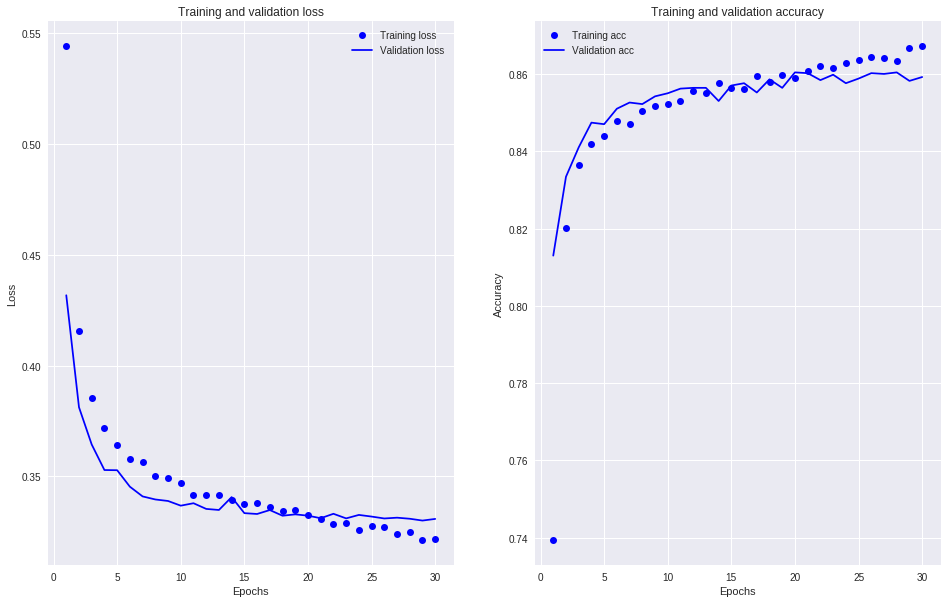

In [26]:
plot_metrics(history)

## Model with Keras Embedding Layer

In [34]:
# define the model
model = Sequential()
model.add(Embedding(input_dim=10000, 
                    output_dim=8, 
                    input_length=200))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# summarize the model
print(model.summary())

# fit the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    #batch_size=64,
                    validation_data=(X_val, y_val), 
                    verbose=1)

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('\nAccuracy: {:.2%}'.format(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 8)            80000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 8)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1601      
Total params: 81,601
Trainable params: 81,601
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 3s 171us/step - loss: 0.66

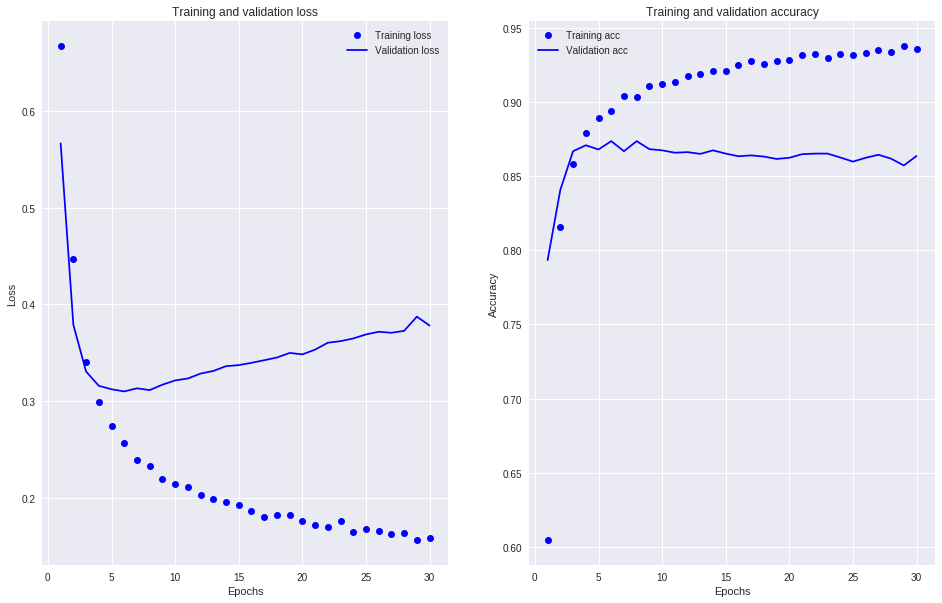

In [35]:
plot_metrics(history)

In [34]:
################################
#########  Experiment  #########
################################

vocab_size = 10000
vecor_length = 8
max_length = 200


# define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=vecor_length))
#model.add(Dropout(0.7))
#model.add(Flatten())
model.add(GlobalAveragePooling1D())
#model.add(LSTM(100))
#model.add(Dropout(0.7))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# summarize the model
print(model.summary())

# fit the model
model.fit(X_train, y_train, epochs=10, batch_size=64)

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('\nAccuracy: {:.2%}'.format(accuracy))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
25000/25000 [==============================] - 2s 95us/step - loss: 0.6916 - acc: 0.5436
Epoch 2/10
25000/25000 [==============================] - 2s 89us/step - loss: 0.6528 - acc: 0.6622
Epoch 3/10
25000/25000 [==============================] - 2s 87us

## Modeling with Word Embedding and RNN

In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 107s 4ms/step - loss: 0.6932 - acc: 0.5056
Epoch 2/10
25000/25000 [==============================] - 93s 4ms/step - loss: 0.7299 - acc: 0.5122
Epoch 3/10
25000/25000 [==============================] - 94s 4ms/step - loss: 0.6650 - acc: 0.5968
Epoch 4/10
25000/25000 [==============================] - 93s 4ms/step - loss: 0.6373 - acc: 0.6454
Epoch 5/10
25000/25000 [==============================] - 94s 4ms/step - loss: 0.6258 - acc: 0.6634
Epoch 6/10
25000/25000 [==============================] - 94s 4ms/step - loss: 0.5549 - acc: 0.7556
Epoch 7/10
25000/25000 [==============================] - 93s 4ms/step - loss: 0.5707 - acc: 0.7102
Epoch 8/10
25000/25000 [==============================] - 93s 4ms/step - loss: 0.4792 - acc: 0.8064
Epoch 9/10
25000/25000 [==============================] - 93s 4ms/step - loss: 0.4071 - acc: 0.8587
Epoch 10/10
25000/25000 [==============================] - 91s 4ms/step - loss: 0.4394 - acc: 0.839

In [25]:
score = model.evaluate(X_test, y_test)
score

25000/25000 [==============================] - 129s 5ms/step


[0.6118534841680526, 0.81644]

## To-Do's
 
- preprocess using spaCy
- lemmatize based on pos: https://stackoverflow.com/questions/41824782/lemmatize-string-according-to-pos-nlp
- 'desk\x97symbol', '\x91alonzo', '137', '230lbs', 'yes\x97it', '1988\x961992', 'yurets777', '94th', '20perr', '\x84new', 
- trim to max length first and then one hot

# Log
- original linearSVC and countervectorizer: 84.14%
- Logistic Regression and tfidf: 88.33%
- Initial NN: 85.05%
- SVC with preprocess: 84.14%
- NN with preprocess and new embed: 85.53%
- Keras embedding and dropout (0.5): 86.33%
- Keras embedding and dropout (0.7): 87.42%
- Keras embedding and dropout (0.7), coverage (400): 86.48%

took 37.5 min to convert to embedding before preprocessing, 20 min after preprocessing.

In [0]:
def cosine_similarity(v1, v2):
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))